# Experimentation and uplift testing

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("QVI_data.csv")

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [3]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


### Let's first create the metrics of interest and filter to stores that are present throughout the pre-trial period.

In [4]:
#### Calculate these measures over time for each store 
#### Over to you! Add a new month ID column in the data with the format yyyymm.

data['MONTH_ID'] = [''.join(x.split('-')[0:2]) for x in data.DATE]
data['MONTH_ID'] = pd.to_numeric(data['MONTH_ID'])
data.MONTH_ID.head()
## Check format of the serie
data.MONTH_ID.dtype

dtype('int64')

In [5]:
# Next, we define the measure calculations to use during the analysis.
# Over to you! For each store and month calculate:
# 1. Total sales
# 2. Number of customers
# 3. Transactions per customer
# 4. Chips per customer
# 5. Average price per unit.

In [6]:
print(data.STORE_NBR.nunique())
print(data.MONTH_ID.nunique())

272
12


In [7]:
# 1. Total Sales
tot_sales = data.groupby(['STORE_NBR', 'MONTH_ID']).TOT_SALES.sum()

In [8]:
# 2. Number of customers
n_customers = data.groupby(['STORE_NBR', 'MONTH_ID']).LYLTY_CARD_NBR.nunique()

In [9]:
# 3. Average transactions per customer
txt_percustomer = data.groupby(['STORE_NBR', 'MONTH_ID']).TXN_ID.nunique() / n_customers

In [10]:
# 4. Chips per customer
total_quantity = data.groupby(['STORE_NBR', 'MONTH_ID']).PROD_QTY.sum()
chips_percustomer = total_quantity / n_customers

In [11]:
# 5. Average price per unit
total_sales = data.groupby(['STORE_NBR', 'MONTH_ID']).TOT_SALES.sum()
avg_price_unit = total_sales/total_quantity

In [12]:
metrics = pd.concat([tot_sales, n_customers, txt_percustomer, chips_percustomer, avg_price_unit], axis = 1)
metrics.columns = ['Total_Sales', 'N_Customers', 'Transaction_PC', 'Chips_PC', 'Avg_price_chips']
metrics = metrics.reset_index()
metrics

,STORE_NBR,MONTH_ID,Total_Sales,N_Customers,Transaction_PC,Chips_PC,Avg_price_chips
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947
...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,2.022222,4.346154
3165,272,201903,442.3,50,1.060000,2.020000,4.379208
3166,272,201904,445.1,54,1.018519,1.944444,4.239048
3167,272,201905,314.6,34,1.176471,2.088235,4.430986


In [13]:
#### Filter to the pre-trial period and stores with full observation periods

# Stores with full observations periods 
counts = metrics['STORE_NBR'].value_counts()
index = counts[counts==12].index
stores_full_obs = metrics[metrics['STORE_NBR'].isin(index)]
stores_full_obs

#Filter to the pre-trial period (201807-201901)
stores_full_obs_pre_trial = stores_full_obs[stores_full_obs['MONTH_ID'] < 201902]
stores_full_obs_pre_trial

,STORE_NBR,MONTH_ID,Total_Sales,N_Customers,Transaction_PC,Chips_PC,Avg_price_chips
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947
...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000,2.218750,4.291549
3160,272,201810,430.6,44,1.136364,2.250000,4.349495
3161,272,201811,376.2,41,1.097561,2.121951,4.324138
3162,272,201812,403.9,47,1.000000,1.893617,4.538202


## Now we need to work out a way of ranking how similar each potential control store is to the trial store. 
We can calculate how correlated the performance of each store is to the trial store. (*Let's write a function for this so that we don't have to calculate this for each trial store and control store pair.*)



###  Over to you! Create a function to calculate correlation for a measure, looping through each control store.

#### Let's define:
 1. **InputTable**: metric table with potential comparison stores.
 2. **MetricCol**: store metric used to calculate correlation on.
 3. **StoreComparison**: the store number of the trial store (trial store).

In [14]:
def calculateCorrelation(inputTable, metricCol, storeComparison):
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'Correlation': []})
    trial = inputTable.loc[inputTable['STORE_NBR'] == storeComparison, metricCol]
    trial.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        control = inputTable.loc[inputTable['STORE_NBR'] == i, metricCol]
        control.reset_index(drop = True, inplace = True)
        output = output.append({'Store1': storeComparison, 'Store2': i, 'Correlation': control.corr(trial)}, ignore_index = True)
    return output

### Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store's performance and each control store's performance.


In [15]:
#### Standardise the magnitude distance so that the measure ranges from 0 to 1

In [16]:
#### Create a function to calculate a standardised magnitude distance for a measure, looping through each control store
import numpy as np
def calculateMagnitudeDistance(inputTable, metricCol, storeComparison):
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'MagnitudeMeasure': []})
    trial = inputTable.loc[inputTable['STORE_NBR'] == storeComparison, metricCol]
    trial.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        control = inputTable.loc[inputTable['STORE_NBR'] == i, metricCol]
        control.reset_index(drop = True, inplace = True)
        diff = abs(trial - control)
        s_diff = np.mean(1-((diff-min(diff))/(max(diff)-min(diff))))
        output = output.append({'Store1': storeComparison, 'Store2': i, 'MagnitudeMeasure': s_diff}, ignore_index = True)
    return output

## Now let's use the functions to find the control stores!

##### We'll select control stores based on:

-How similar are to the trial stores in terms of:
1. Monthly total sales in dollar amounts
2. Monthly number of customers 

We will need to use our functions to get:
-Four scores, two for each of total sales and total customers.

## Trial Store 77

In [17]:
storeComparison = 77
# Calculate correlations against store 77 using total sales and number of customers
corr_sales = calculateCorrelation(stores_full_obs_pre_trial, 'Total_Sales', storeComparison)
corr_ncustomers = calculateCorrelation(stores_full_obs_pre_trial, 'N_Customers', storeComparison)

# Calculate magnitude measure against store 77 using total sales and number of customers
magnitude_sales = calculateMagnitudeDistance(stores_full_obs_pre_trial, 'Total_Sales', storeComparison)
magnitude_ncustomers = calculateMagnitudeDistance(stores_full_obs_pre_trial, 'N_Customers', storeComparison)

In [18]:
print(corr_sales.head())
print(corr_ncustomers.head())
print(magnitude_sales.head())
print(magnitude_ncustomers.head())

   Store1  Store2  Correlation
0    77.0     1.0     0.075218
1    77.0     2.0    -0.263079
2    77.0     3.0     0.806644
3    77.0     4.0    -0.263300
4    77.0     5.0    -0.110652
   Store1  Store2  Correlation
0    77.0     1.0     0.322168
1    77.0     2.0    -0.572051
2    77.0     3.0     0.834207
3    77.0     4.0    -0.295639
4    77.0     5.0     0.370659
   Store1  Store2  MagnitudeMeasure
0    77.0     1.0          0.408163
1    77.0     2.0          0.590119
2    77.0     3.0          0.522914
3    77.0     4.0          0.644934
4    77.0     5.0          0.516320
   Store1  Store2  MagnitudeMeasure
0    77.0     1.0          0.663866
1    77.0     2.0          0.471429
2    77.0     3.0          0.489796
3    77.0     4.0          0.498258
4    77.0     5.0          0.512605


## We'll need to combine the all the scores calculated using our function to create a composite score to rank on. 

Let's take a simple average of the correlation and magnitude scores for each driver. 

Note that:

1. If we consider it more important for the trend of the drivers to be similar: 

We can **increase** the weight of the correlation score *(a simple average gives a weight of 0.5 to the corr_weight).

2. If we consider the absolute size of the drivers to be more important:

We can **lower** the weight of the correlation score.

In [19]:
#### Over to you! Create a combined score composed of correlation and magnitude, by first merging the correlations table with the magnitude table.
corr_sales = corr_sales.rename(columns={'Correlation':'Correlation_Sales'})
magnitude_sales = magnitude_sales.rename(columns={'MagnitudeMeasure': 'Magnitude_Sales'})

In [20]:
corr_ncustomers = corr_ncustomers.rename(columns={'Correlation':'Correlation_NCustomers'})
magnitude_ncustomers = magnitude_ncustomers.rename(columns={'MagnitudeMeasure':'Magnitude_Ncustomers'})

In [21]:
sales = pd.merge(corr_sales, magnitude_sales, left_index=False, right_index=False)
ncustomers = pd.merge(corr_ncustomers, magnitude_ncustomers, left_index=False, right_index=False)

In [22]:
#### Hint: A simple average on the scores would be 0.5 * corr_measure + 0.5 * mag_measure
corr_measure = 0.5
# 1. Sales Table
sales['combined_score_sales'] = ((corr_measure * sales['Correlation_Sales']) + ((1-corr_measure)*sales['Magnitude_Sales']))
sales.head()

,Store1,Store2,Correlation_Sales,Magnitude_Sales,combined_score_sales
0,77.0,1.0,0.075218,0.408163,0.241691
1,77.0,2.0,-0.263079,0.590119,0.163520
2,77.0,3.0,0.806644,0.522914,0.664779
3,77.0,4.0,-0.263300,0.644934,0.190817
4,77.0,5.0,-0.110652,0.516320,0.202834


In [23]:
# 2. N_Customers Table
ncustomers['combined_score_ncustomers'] = ((corr_measure * ncustomers['Correlation_NCustomers']) + ((1-corr_measure)*ncustomers['Magnitude_Ncustomers']))
ncustomers.head()

,Store1,Store2,Correlation_NCustomers,Magnitude_Ncustomers,combined_score_ncustomers
0,77.0,1.0,0.322168,0.663866,0.493017
1,77.0,2.0,-0.572051,0.471429,-0.050311
2,77.0,3.0,0.834207,0.489796,0.662002
3,77.0,4.0,-0.295639,0.498258,0.101310
4,77.0,5.0,0.370659,0.512605,0.441632


In [24]:
#Now we have a score for each of total number of sales and number of customers. Let's combine the two via a simple average.
### Over to you! Combine scores across the drivers by first merging our sales scores and customer scores into a single table.

final_score = pd.merge(sales, ncustomers, left_index=False, right_index=False)
final_score = final_score.drop(['Correlation_Sales','Magnitude_Sales', 'Correlation_NCustomers', 'Magnitude_Ncustomers'], axis=1)
final_score['final_score'] = ((corr_measure * final_score['combined_score_sales']) + ((1-corr_measure)*final_score['combined_score_ncustomers']))
final_score.head()

,Store1,Store2,combined_score_sales,combined_score_ncustomers,final_score
0,77.0,1.0,0.241691,0.493017,0.367354
1,77.0,2.0,0.163520,-0.050311,0.056604
2,77.0,3.0,0.664779,0.662002,0.663390
3,77.0,4.0,0.190817,0.101310,0.146064
4,77.0,5.0,0.202834,0.441632,0.322233


 
Select control stores based on the highest matching store (closest to 1 but  not the store itself, i.e. the second ranked highest store)

In [25]:
#### Over to you! Select the most appropriate control store for trial store 77 by finding the store with the highest final score
final_score.sort_values('final_score', ascending=False).head(10)

,Store1,Store2,combined_score_sales,combined_score_ncustomers,final_score
221,77.0,233.0,0.697290,0.816607,0.756949
67,77.0,71.0,0.789497,0.663123,0.726310
79,77.0,84.0,0.656972,0.715000,0.685986
111,77.0,119.0,0.636046,0.729729,0.682887
108,77.0,115.0,0.708347,0.645155,0.676751
46,77.0,50.0,0.697113,0.634053,0.665583
2,77.0,3.0,0.664779,0.662002,0.663390
38,77.0,41.0,0.637458,0.679253,0.658356
252,77.0,265.0,0.659165,0.639671,0.649418
15,77.0,17.0,0.626062,0.659368,0.642715


#### Now that we have found a control store, let's check visually if the drivers are indeed similar in the period before the trial.

In [26]:
#### Visual checks on trends based on the drivers
#We'll look at total sales first.

In [27]:
stores = [77, 233]
filtered_metrics = stores_full_obs_pre_trial[stores_full_obs_pre_trial.STORE_NBR.isin(stores)]
filtered_metrics.STORE_NBR.unique()

array([ 77, 233], dtype=int64)

In [28]:
filtered_metrics.head()

,STORE_NBR,MONTH_ID,Total_Sales,N_Customers,Transaction_PC,Chips_PC,Avg_price_chips
880,77,201807,296.8,51,1.078431,1.647059,3.533333
881,77,201808,255.5,47,1.021277,1.574468,3.452703
882,77,201809,225.2,42,1.047619,1.666667,3.217143
883,77,201810,204.5,37,1.027027,1.405405,3.932692
884,77,201811,245.3,41,1.073171,1.634146,3.661194


In [29]:
filtered_metrics['MONTH_ID'] = pd.to_datetime(filtered_metrics['MONTH_ID'], format="%Y%m")
filtered_metrics['MONTH_ID'].head()

C:\Users\7Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


880   2018-07-01
881   2018-08-01
882   2018-09-01
883   2018-10-01
884   2018-11-01
Name: MONTH_ID, dtype: datetime64[ns]

In [192]:
trial = [77]
trial_store = filtered_metrics[filtered_metrics.STORE_NBR.isin(trial)]
c = pd.pivot_table(trial_store, values='Total_Sales', index='MONTH_ID')

control=[233]
control_store = filtered_metrics[filtered_metrics.STORE_NBR.isin(control)]
d = pd.pivot_table(control_store, values='Total_Sales', index='MONTH_ID')

print(c.head())
print(d.head())

            Total_Sales
MONTH_ID               
2018-07-01        296.8
2018-08-01        255.5
2018-09-01        225.2
2018-10-01        204.5
2018-11-01        245.3
            Total_Sales
MONTH_ID               
2018-07-01        290.7
2018-08-01        285.9
2018-09-01        228.6
2018-10-01        185.7
2018-11-01        211.6


<IPython.core.display.Javascript object>


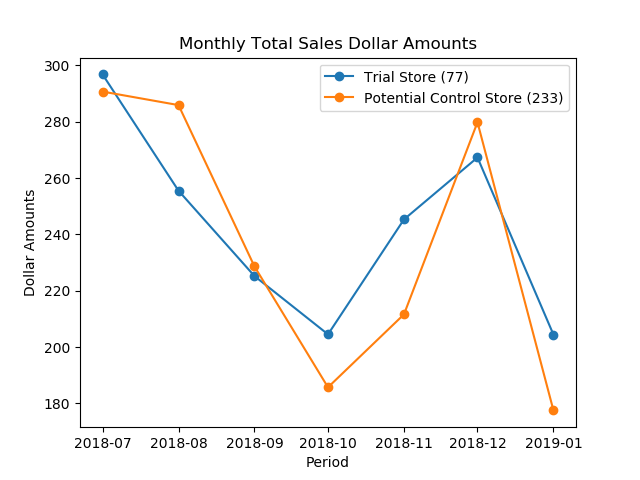

In [193]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(c, '-o', d, '-o')

In [194]:
plt.xlabel('Period')
plt.ylabel('Dollar Amounts')
plt.title('Monthly Total Sales Dollar Amounts')
plt.legend(['Trial Store (77)', 'Control Store (233)'])

In [33]:
#### Next, number of customers.
#### Over to you! Conduct visual checks on customer count trends by comparing the trial store to the control 
#### store and other stores.

In [34]:
trial_store0 = 77
control_store0 = 233

In [35]:
# Create a new dataframe 'pastSales'
measures = stores_full_obs_pre_trial

# Create a new column within 'pastSales' which categorises store type
store_type = []

for i in measures['STORE_NBR']:
    if i == trial_store0:
        store_type.append('Trial Store')
    elif i == control_store0:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

measures['store_type'] = store_type
measures['MONTH_ID'] = pd.to_datetime(measures['MONTH_ID'], format="%Y%m")
measures.head()

C:\Users\7Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\7Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,STORE_NBR,MONTH_ID,Total_Sales,N_Customers,Transaction_PC,Chips_PC,Avg_price_chips,store_type
0,1,2018-07-01,206.9,49,1.061224,1.265306,3.337097,Other Stores
1,1,2018-08-01,176.1,42,1.023810,1.285714,3.261111,Other Stores
2,1,2018-09-01,278.8,59,1.050847,1.271186,3.717333,Other Stores
3,1,2018-10-01,188.1,44,1.022727,1.318182,3.243103,Other Stores
4,1,2018-11-01,192.6,46,1.021739,1.239130,3.378947,Other Stores


In [195]:
trial = [77]
trial_store = measures[measures.STORE_NBR.isin(trial)]
c = pd.pivot_table(trial_store, values='N_Customers', index='MONTH_ID')

control=[233]
control_store = measures[measures.STORE_NBR.isin(control)]
d = pd.pivot_table(control_store, values='N_Customers', index='MONTH_ID')

<IPython.core.display.Javascript object>


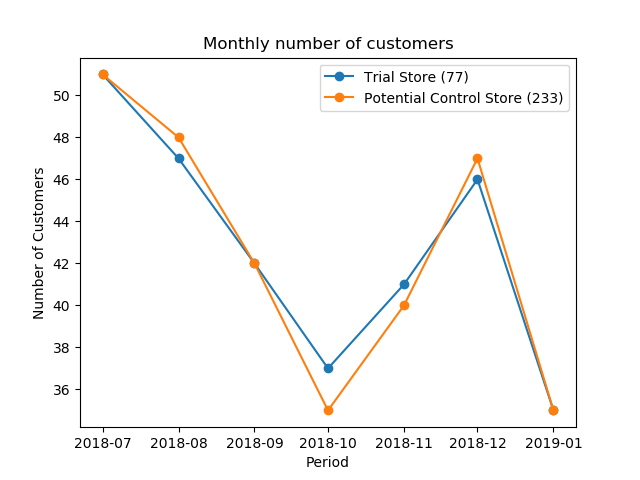

In [196]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(c, '-o', d, '-o')

In [206]:
plt.xlabel('Period')
plt.ylabel('Number of Customers')
plt.title('Monthly number of customers')
plt.legend(['Trial Store (77)', 'Control Store (233)', 'Other Stores'])

#### The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales. 

 We'll start with scaling the control store's sales to a level similar to trial stores for any differences between 
 the two stores outside of the trial period. 

In [40]:
stores_full_obs[stores_full_obs['STORE_NBR'] == 77]['Total_Sales']

880    296.8
881    255.5
882    225.2
883    204.5
884    245.3
885    267.3
886    204.4
887    235.0
888    278.5
889    263.5
890    299.3
891    264.7
Name: Total_Sales, dtype: float64

In [41]:
stores_full_obs[stores_full_obs['STORE_NBR'] == 77]['Total_Sales'].sum()

3040.0

In [42]:
pre_trial_trial = stores_full_obs_pre_trial[stores_full_obs_pre_trial['STORE_NBR'] == 77]['Total_Sales'].sum()
pre_trial_control = stores_full_obs_pre_trial[stores_full_obs_pre_trial['STORE_NBR'] == 233]['Total_Sales'].sum()

In [43]:
# Scale pre-trial control sales to match pre-trial trial store sales
scalingfactor = pre_trial_trial/pre_trial_control
scalingfactor

1.023617303289553

In [44]:
#### Apply the scaling factor
stores_full_obs_233 = stores_full_obs[stores_full_obs['STORE_NBR'] == 233]
stores_full_obs_233['scaled_control_sales'] = stores_full_obs_233['Total_Sales']*scalingfactor
stores_full_obs_233.reset_index(drop=True).head()

C:\Users\7Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,STORE_NBR,MONTH_ID,Total_Sales,N_Customers,Transaction_PC,Chips_PC,Avg_price_chips,scaled_control_sales
0,233,201807,290.7,51,1.058824,1.725490,3.303409,297.565550
1,233,201808,285.9,48,1.041667,1.666667,3.573750,292.652187
2,233,201809,228.6,42,1.071429,1.666667,3.265714,233.998916
3,233,201810,185.7,35,1.028571,1.600000,3.316071,190.085733
4,233,201811,211.6,40,1.025000,1.550000,3.412903,216.597421


In [45]:
### Now that we have comparable sales figures for the control store, we can calculate the percentage difference 
### between the scaled control sales and the trial store's sales during the trial period.

scaled_control =stores_full_obs_233[['MONTH_ID', 'scaled_control_sales']].reset_index(drop=True)

trialsales = metrics[metrics['STORE_NBR'] == 77].reset_index(drop=True)
trialsales = trialsales[['MONTH_ID', 'Total_Sales']]

#### Over to you! Calculate the percentage difference between scaled control sales and trial sales
per_diff = pd.merge(scaled_control, trialsales, left_index=False, right_index=False)
per_diff['percentagedifference'] = abs(per_diff.scaled_control_sales - per_diff.Total_Sales) / per_diff.scaled_control_sales
per_diff

,MONTH_ID,scaled_control_sales,Total_Sales,percentagedifference
0,201807,297.565550,296.8,0.002573
1,201808,292.652187,255.5,0.126950
2,201809,233.998916,225.2,0.037602
3,201810,190.085733,204.5,0.075830
4,201811,216.597421,245.3,0.132516
5,201812,286.408121,267.3,0.066716
6,201901,181.692071,204.4,0.124980
7,201902,249.762622,235.0,0.059107
8,201903,203.802205,278.5,0.366521
9,201904,162.345704,263.5,0.623080


# Let's see if the difference is significant!
### Null Hypothesis: Trial Period is the same as Pre-Trial Period

In [46]:
## Let's take the standard deviation based on the scaled percentage difference in the pre-trial period:
std = (per_diff[per_diff['MONTH_ID'] < 201902]['percentagedifference']).std()
std

0.049940762641425544

In [47]:
# Note that there are 8 months in the pre-trial period hence 8 - 1 = 7 degrees of freedom
df = 7

 We will test with a null hypothesis of there being 0 difference between trial and control stores.
### Null Hypothesis: There being 0 difference between trial and control stores

In [48]:
#### Over to you! Calculate the t-values for the trial months.
per_diff['t_values'] = (per_diff['percentagedifference']-0)/std
per_diff.loc[(per_diff['MONTH_ID'] > 201901), 't_values']

7      1.183534
8      7.339116
9     12.476373
10     3.023650
11     3.406093
Name: t_values, dtype: float64

In [49]:
### Find the 95th percentile of the t distribution with  the appropriate degrees of freedom to check whether 
### the hypothesis is statistically significant.

from scipy.stats import t
t.isf(0.05, df)
## 95th percentile of the t distribution

1.8945786050613054

 We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April.
- **i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.**

### Let's create a more visual version of this by plotting:
1. The sales of the control store
2. The sales of the trial stores 
3. The 95th percentile value of sales of the control store.

In [199]:
#### Control store 95th and 5th percentile
control = per_diff[['MONTH_ID', 'scaled_control_sales']]
control['MONTH_ID'] = pd.to_datetime(control['MONTH_ID'], format="%Y%m")                    
#control = control.set_index('MONTH_ID')
control['5% CI'] = control['scaled_control_sales'] * (1 - std*2)
control['95% CI'] = control['scaled_control_sales'] * (1 + std*2)
control

C:\Users\7Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\7Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,MONTH_ID,scaled_control_sales,5% CI,95% CI
0,2018-07-01,896.922236,877.750622,916.093850
1,2018-08-01,759.269991,743.040679,775.499304
2,2018-09-01,984.034086,963.000466,1005.067706
3,2018-10-01,934.948790,914.964363,954.933217
4,2018-11-01,871.894555,853.257905,890.531205
5,2018-12-01,824.361363,806.740730,841.981996
6,2019-01-01,848.418979,830.284117,866.553840
7,2019-02-01,864.522060,846.042997,883.001123
8,2019-03-01,780.320405,763.641143,796.999668
9,2019-04-01,819.317024,801.804213,836.829835


In [200]:
trial = per_diff[['MONTH_ID', 'Total_Sales']]
trial['MONTH_ID'] = pd.to_datetime(trial['MONTH_ID'], format="%Y%m")
#trial = trial.set_index('MONTH_ID')
trial

C:\Users\7Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MONTH_ID,Total_Sales
0,2018-07-01,892.20
1,2018-08-01,764.05
2,2018-09-01,914.60
3,2018-10-01,948.40
4,2018-11-01,918.00
5,2018-12-01,841.20
6,2019-01-01,841.40
7,2019-02-01,913.20
8,2019-03-01,1026.80
9,2019-04-01,848.20


In [201]:
combinedsales = pd.merge(control, trial, left_index=False, right_index=False)
combinedsales = combinedsales.rename(columns= {'scaled_control_sales': 'control_sales', 'Total_Sales':'trial_sales'})
#combinedsales['MONTH_ID'] = pd.to_datetime(combinedsales['MONTH_ID'], format="%Y%m")
combinedsales.head()

,MONTH_ID,control_sales,5% CI,95% CI,trial_sales
0,2018-07-01,896.922236,877.750622,916.093850,892.20
1,2018-08-01,759.269991,743.040679,775.499304,764.05
2,2018-09-01,984.034086,963.000466,1005.067706,914.60
3,2018-10-01,934.948790,914.964363,954.933217,948.40
4,2018-11-01,871.894555,853.257905,890.531205,918.00


In [202]:
a = pd.pivot_table(combinedsales, values='control_sales', index='MONTH_ID')
b = pd.pivot_table(combinedsales, values='trial_sales', index='MONTH_ID')
c = pd.pivot_table(combinedsales, values='5% CI', index='MONTH_ID')
d = pd.pivot_table(combinedsales, values='95% CI', index='MONTH_ID')

<IPython.core.display.Javascript object>


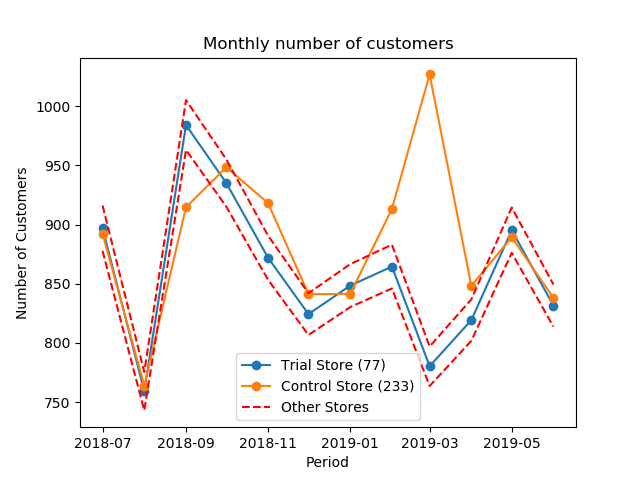

In [203]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(a, '-o', b, '-o', c, '--r', d, '--r')

In [205]:
plt.xlabel('Period')
plt.ylabel('Total Amount of Sales')
plt.title('Total Sales per Month')
plt.legend(['Control Stores (77) - Sales', 'Trial Stores - Sales', 'CI 5% Control Store', 'CI 95% Control Store'])

## Trial Store 86

In [56]:
storeComparison = 86

#### Over to you! Use the functions we created earlier to calculate correlations and magnitude for each potential control store

# Calculate correlations against store 86 using total sales and number of customers
corr_sales = calculateCorrelation(stores_full_obs_pre_trial, 'Total_Sales', storeComparison)
corr_ncustomers = calculateCorrelation(stores_full_obs_pre_trial, 'N_Customers', storeComparison)

# Calculate magnitude measure against store 86 using total sales and number of customers
magnitude_sales = calculateMagnitudeDistance(stores_full_obs_pre_trial, 'Total_Sales', storeComparison)
magnitude_ncustomers = calculateMagnitudeDistance(stores_full_obs_pre_trial, 'N_Customers', storeComparison)

In [57]:
print(corr_sales.head())
print(corr_ncustomers.head())
print(magnitude_sales.head())
print(magnitude_ncustomers.head())

   Store1  Store2  Correlation
0    86.0     1.0     0.445632
1    86.0     2.0    -0.403835
2    86.0     3.0    -0.261284
3    86.0     4.0    -0.039035
4    86.0     5.0     0.235159
   Store1  Store2  Correlation
0    86.0     1.0     0.485831
1    86.0     2.0    -0.086161
2    86.0     3.0    -0.353786
3    86.0     4.0    -0.169608
4    86.0     5.0    -0.253229
   Store1  Store2  MagnitudeMeasure
0    86.0     1.0          0.488334
1    86.0     2.0          0.321131
2    86.0     3.0          0.507515
3    86.0     4.0          0.635654
4    86.0     5.0          0.579835
   Store1  Store2  MagnitudeMeasure
0    86.0     1.0          0.510204
1    86.0     2.0          0.428571
2    86.0     3.0          0.563025
3    86.0     4.0          0.537815
4    86.0     5.0          0.714286


In [58]:
#### Now, create a combined score composed of correlation and magnitude
corr_sales = corr_sales.rename(columns={'Correlation':'Correlation_Sales'})
magnitude_sales = magnitude_sales.rename(columns={'MagnitudeMeasure': 'Magnitude_Sales'})
corr_ncustomers = corr_ncustomers.rename(columns={'Correlation':'Correlation_NCustomers'})
magnitude_ncustomers = magnitude_ncustomers.rename(columns={'MagnitudeMeasure':'Magnitude_Ncustomers'})

In [59]:
sales = pd.merge(corr_sales, magnitude_sales, left_index=False, right_index=False)
ncustomers = pd.merge(corr_ncustomers, magnitude_ncustomers, left_index=False, right_index=False)

In [60]:
#### Hint: A simple average on the scores would be 0.5 * corr_measure + 0.5 * mag_measure
#### Finally, combine scores across the drivers using a simple average.
corr_measure = 0.5
# 1. Sales Table
sales['combined_score_sales'] = ((corr_measure * sales['Correlation_Sales']) + ((1-corr_measure)*sales['Magnitude_Sales']))
sales.head()

,Store1,Store2,Correlation_Sales,Magnitude_Sales,combined_score_sales
0,86.0,1.0,0.445632,0.488334,0.466983
1,86.0,2.0,-0.403835,0.321131,-0.041352
2,86.0,3.0,-0.261284,0.507515,0.123116
3,86.0,4.0,-0.039035,0.635654,0.298309
4,86.0,5.0,0.235159,0.579835,0.407497


In [61]:
# 2. N_Customers Table
ncustomers['combined_score_ncustomers'] = ((corr_measure * ncustomers['Correlation_NCustomers']) + ((1-corr_measure)*ncustomers['Magnitude_Ncustomers']))
ncustomers.head()

,Store1,Store2,Correlation_NCustomers,Magnitude_Ncustomers,combined_score_ncustomers
0,86.0,1.0,0.485831,0.510204,0.498018
1,86.0,2.0,-0.086161,0.428571,0.171205
2,86.0,3.0,-0.353786,0.563025,0.104620
3,86.0,4.0,-0.169608,0.537815,0.184103
4,86.0,5.0,-0.253229,0.714286,0.230528


In [62]:
#Now we have a score for each of total number of sales and number of customers. Let's combine the two via a simple average.
### Over to you! Combine scores across the drivers by first merging our sales scores and customer scores into a single table.
final_score = pd.merge(sales, ncustomers, left_index=False, right_index=False)
final_score = final_score.drop(['Correlation_Sales','Magnitude_Sales', 'Correlation_NCustomers', 'Magnitude_Ncustomers'], axis=1)
final_score['final_score'] = ((corr_measure * final_score['combined_score_sales']) + ((1-corr_measure)*final_score['combined_score_ncustomers']))
final_score.head()

,Store1,Store2,combined_score_sales,combined_score_ncustomers,final_score
0,86.0,1.0,0.466983,0.498018,0.482500
1,86.0,2.0,-0.041352,0.171205,0.064927
2,86.0,3.0,0.123116,0.104620,0.113868
3,86.0,4.0,0.298309,0.184103,0.241206
4,86.0,5.0,0.407497,0.230528,0.319013


In [63]:
#### Select control stores based on the highest matching store
#### (closest to 1 but not the store itself, i.e. the second ranked highest store)
final_score.sort_values('final_score', ascending=False).head(10)

,Store1,Store2,combined_score_sales,combined_score_ncustomers,final_score
147,86.0,155.0,0.808106,0.733343,0.770724
102,86.0,109.0,0.697120,0.742532,0.719826
107,86.0,114.0,0.631393,0.663384,0.647389
213,86.0,225.0,0.601841,0.684356,0.643099
130,86.0,138.0,0.593296,0.660565,0.626930
228,86.0,240.0,0.617320,0.593396,0.605358
173,86.0,181.0,0.589568,0.611400,0.600484
247,86.0,260.0,0.558740,0.637537,0.598138
210,86.0,222.0,0.668333,0.525038,0.596685
185,86.0,194.0,0.580335,0.577601,0.578968


In [117]:
#### Visual checks on trends based on the drivers
#We'll look at total sales first.
trial = [86]
trial_store = measures[measures.STORE_NBR.isin(trial)]
c = pd.pivot_table(trial_store, values='Total_Sales', index='MONTH_ID')

control=[155]
control_store = measures[measures.STORE_NBR.isin(control)]
d = pd.pivot_table(control_store, values='Total_Sales', index='MONTH_ID')

other = ['Other Stores']
other_store = measures[measures.store_type.isin(other)]
e = pd.pivot_table(other_store, values='Total_Sales', index='MONTH_ID')

<IPython.core.display.Javascript object>


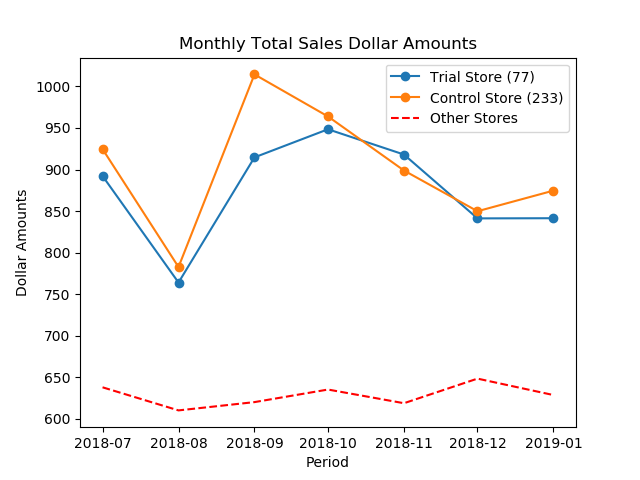

In [118]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(c, '-o', d, '-o')

In [119]:
plt.plot(e, '--r')

In [120]:
plt.xlabel('Period')
plt.ylabel('Dollar Amounts')
plt.title('Monthly Total Sales Dollar Amounts')
plt.legend(['Trial Store (77)', 'Control Store (233)', 'Other Stores'])

In [121]:
# Next, number of customers.
trial = [86]
trial_store = measures[measures.STORE_NBR.isin(trial)]
c = pd.pivot_table(trial_store, values='N_Customers', index='MONTH_ID')

control=[155]
control_store = measures[measures.STORE_NBR.isin(control)]
d = pd.pivot_table(control_store, values='N_Customers', index='MONTH_ID')

<IPython.core.display.Javascript object>


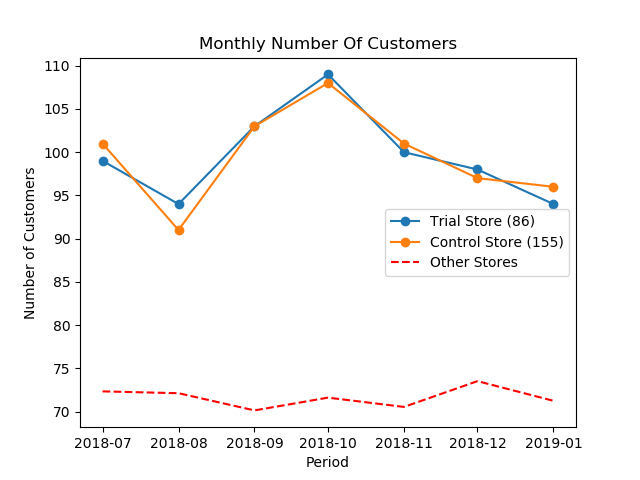

In [122]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(c, '-o', d, '-o')

In [124]:
plt.xlabel('Period')
plt.ylabel('Number of Customers')
plt.title('Monthly Number Of Customers')
plt.legend(['Trial Store (86)', 'Control Store (155)', 'Other Stores'])

In [72]:
#Let's now assess the impact of the trial on sales.

In [125]:
#### Scale pre-trial control sales to match pre-trial trial store sales 
pre_trial_trial = stores_full_obs_pre_trial[stores_full_obs_pre_trial['STORE_NBR'] == 86]['Total_Sales'].sum()
pre_trial_control = stores_full_obs_pre_trial[stores_full_obs_pre_trial['STORE_NBR'] == 155]['Total_Sales'].sum()

In [126]:
#### Apply the scaling factor
scalingfactor = pre_trial_trial/pre_trial_control
stores_full_obs_155 = stores_full_obs[stores_full_obs['STORE_NBR'] == 155]
stores_full_obs_155['scaled_control_sales'] = stores_full_obs_155['Total_Sales']*scalingfactor
stores_full_obs_155.reset_index(drop=True).head()

C:\Users\7Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,STORE_NBR,MONTH_ID,Total_Sales,N_Customers,Transaction_PC,Chips_PC,Avg_price_chips,scaled_control_sales
0,155,201807,924.6,101,1.217822,2.475248,3.698400,896.922236
1,155,201808,782.7,91,1.307692,2.516484,3.417904,759.269991
2,155,201809,1014.4,103,1.398058,2.815534,3.497931,984.034086
3,155,201810,963.8,108,1.259259,2.518519,3.543382,934.948790
4,155,201811,898.8,101,1.316832,2.673267,3.328889,871.894555


In [127]:
#### Over to you! Calculate the percentage difference between scaled control sales and trial sales
#### Hint: When calculating percentage difference, remember to use absolute difference 
scaled_control =stores_full_obs_155[['MONTH_ID', 'scaled_control_sales']].reset_index(drop=True)

trialsales = metrics[metrics['STORE_NBR'] == 86].reset_index(drop=True)
trialsales = trialsales[['MONTH_ID', 'Total_Sales']]

per_diff = pd.merge(scaled_control, trialsales, left_index=False, right_index=False)
per_diff['percentagedifference'] = abs(per_diff.scaled_control_sales - per_diff.Total_Sales) / per_diff.scaled_control_sales
per_diff

,MONTH_ID,scaled_control_sales,Total_Sales,percentagedifference
0,201807,896.922236,892.20,0.005265
1,201808,759.269991,764.05,0.006296
2,201809,984.034086,914.60,0.070561
3,201810,934.948790,948.40,0.014387
4,201811,871.894555,918.00,0.052880
5,201812,824.361363,841.20,0.020426
6,201901,848.418979,841.40,0.008273
7,201902,864.522060,913.20,0.056306
8,201903,780.320405,1026.80,0.315870
9,201904,819.317024,848.20,0.035253


In [128]:
#### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation 
#### based on the scaled percentage difference in the pre-trial period.
#### Over to you! Calculate the standard deviation of percentage differences during the pre-trial period

std = (per_diff[per_diff['MONTH_ID'] < 201902]['percentagedifference'].std())
std

0.025833952854772586

In [129]:
## degreesOfFreedom <- 7
df = 7

In [130]:
#### Trial and control store total sales
#### Over to you! Create a table with sales by store type and month.
#### Hint: We only need data for the trial and control store.
#DONE: scaled_control_sales --> Control Sales & Total_Sales --> Trial Sales

In [131]:
#### Over to you! Calculate the 5th and 95th percentile for control store sales.
#### Hint: The 5th and 95th percentiles can be approximated by using two standard deviations away from the mean.
#### Hint2: Recall that the variable stdDev earlier calculates standard deviation in percentages, and not dollar sales.

control = per_diff[['MONTH_ID', 'scaled_control_sales']]
control['MONTH_ID'] = pd.to_datetime(control['MONTH_ID'], format="%Y%m")                    
#control = control.set_index('MONTH_ID')
control['5% CI'] = control['scaled_control_sales'] * (1 - std*2)
control['95% CI'] = control['scaled_control_sales'] * (1 + std*2)
control

C:\Users\7Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\7Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MONTH_ID,scaled_control_sales,5% CI,95% CI
0,2018-07-01,896.922236,850.580142,943.264329
1,2018-08-01,759.269991,720.040101,798.499882
2,2018-09-01,984.034086,933.191106,1034.877067
3,2018-10-01,934.948790,886.641944,983.255636
4,2018-11-01,871.894555,826.845589,916.943521
5,2018-12-01,824.361363,781.768338,866.954388
6,2019-01-01,848.418979,804.582947,892.255010
7,2019-02-01,864.522060,819.854016,909.190104
8,2019-03-01,780.320405,740.002884,820.637926
9,2019-04-01,819.317024,776.984629,861.649419


In [132]:
trial = per_diff[['MONTH_ID', 'Total_Sales']]
trial['MONTH_ID'] = pd.to_datetime(trial['MONTH_ID'], format="%Y%m")
#trial = trial.set_index('MONTH_ID')
trial

C:\Users\7Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MONTH_ID,Total_Sales
0,2018-07-01,892.20
1,2018-08-01,764.05
2,2018-09-01,914.60
3,2018-10-01,948.40
4,2018-11-01,918.00
5,2018-12-01,841.20
6,2019-01-01,841.40
7,2019-02-01,913.20
8,2019-03-01,1026.80
9,2019-04-01,848.20


In [133]:
#### Then, create a combined table with columns
combinedsales = pd.merge(control, trial, left_index=False, right_index=False)
combinedsales = combinedsales.rename(columns= {'scaled_control_sales': 'control_sales', 'Total_Sales':'trial_sales'})
#combinedsales['MONTH_ID'] = pd.to_datetime(combinedsales['MONTH_ID'], format="%Y%m")
combinedsales.head()

,MONTH_ID,control_sales,5% CI,95% CI,trial_sales
0,2018-07-01,896.922236,850.580142,943.264329,892.20
1,2018-08-01,759.269991,720.040101,798.499882,764.05
2,2018-09-01,984.034086,933.191106,1034.877067,914.60
3,2018-10-01,934.948790,886.641944,983.255636,948.40
4,2018-11-01,871.894555,826.845589,916.943521,918.00


In [134]:
a = pd.pivot_table(combinedsales, values='control_sales', index='MONTH_ID')
b = pd.pivot_table(combinedsales, values='trial_sales', index='MONTH_ID')
c = pd.pivot_table(combinedsales, values='5% CI', index='MONTH_ID')
d = pd.pivot_table(combinedsales, values='95% CI', index='MONTH_ID')

<IPython.core.display.Javascript object>


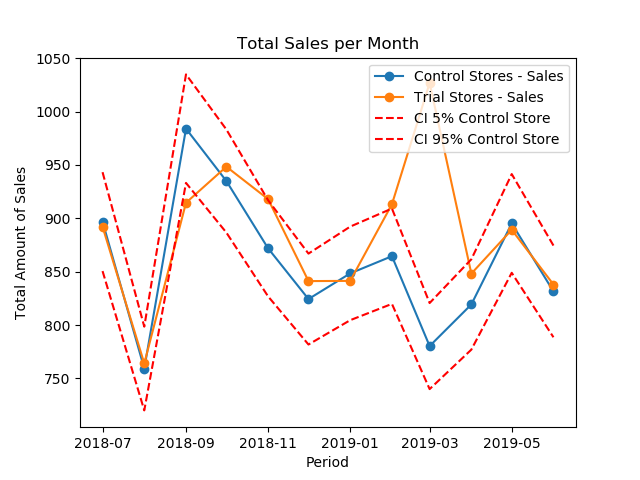

In [135]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(a, '-o', b, '-o', c, '--r', d, '--r')

In [136]:
plt.xlabel('Period')
plt.ylabel('Total Amount of Sales')
plt.title('Total Sales per Month')
plt.legend(['Control Stores - Sales', 'Trial Stores - Sales', 'CI 5% Control Store', 'CI 95% Control Store'])

### Let's have a look at assessing this for the number of customers as well.

In [137]:
#### This would be a repeat of the steps before for total sales
#### Scale pre-trial control customers to match pre-trial trial store customers 
pre_trial_trial = stores_full_obs_pre_trial[stores_full_obs_pre_trial['STORE_NBR'] == 86]['N_Customers'].sum()
pre_trial_control = stores_full_obs_pre_trial[stores_full_obs_pre_trial['STORE_NBR'] == 155]['N_Customers'].sum()

In [138]:
scalingfactor = pre_trial_trial / pre_trial_control
scalingfactor

1.0

In [139]:
stores_full_obs

,STORE_NBR,MONTH_ID,Total_Sales,N_Customers,Transaction_PC,Chips_PC,Avg_price_chips
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947
...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,2.022222,4.346154
3165,272,201903,442.3,50,1.060000,2.020000,4.379208
3166,272,201904,445.1,54,1.018519,1.944444,4.239048
3167,272,201905,314.6,34,1.176471,2.088235,4.430986


In [140]:
#### Apply the scaling factor
stores_full_obs_155['scaled_customers_control'] = stores_full_obs_155['N_Customers']*scalingfactor
stores_full_obs_155.head()

C:\Users\7Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR,MONTH_ID,Total_Sales,N_Customers,Transaction_PC,Chips_PC,Avg_price_chips,scaled_control_sales,scaled_customers_control
1793,155,201807,924.6,101,1.217822,2.475248,3.698400,896.922236,101.0
1794,155,201808,782.7,91,1.307692,2.516484,3.417904,759.269991,91.0
1795,155,201809,1014.4,103,1.398058,2.815534,3.497931,984.034086,103.0
1796,155,201810,963.8,108,1.259259,2.518519,3.543382,934.948790,108.0
1797,155,201811,898.8,101,1.316832,2.673267,3.328889,871.894555,101.0


In [141]:
stores_full_obs_155 = stores_full_obs_155[['MONTH_ID', 'scaled_customers_control']].reset_index(drop=True)
stores_full_obs_155

,MONTH_ID,scaled_customers_control
0,201807,101.0
1,201808,91.0
2,201809,103.0
3,201810,108.0
4,201811,101.0
5,201812,97.0
6,201901,96.0
7,201902,95.0
8,201903,94.0
9,201904,99.0


In [142]:
#### Calculate the percentage difference between scaled control sales and trial sales
trial_customers = metrics[metrics['STORE_NBR'] == 86]
trial_customers = trial_customers[['MONTH_ID', 'N_Customers']].reset_index(drop=True)
trial_customers

,MONTH_ID,N_Customers
0,201807,99
1,201808,94
2,201809,103
3,201810,109
4,201811,100
5,201812,98
6,201901,94
7,201902,107
8,201903,115
9,201904,105


In [143]:
customers = pd.merge(stores_full_obs_155, trial_customers, left_index=False, right_index=False)
customers

,MONTH_ID,scaled_customers_control,N_Customers
0,201807,101.0,99
1,201808,91.0,94
2,201809,103.0,103
3,201810,108.0,109
4,201811,101.0,100
5,201812,97.0,98
6,201901,96.0,94
7,201902,95.0,107
8,201903,94.0,115
9,201904,99.0,105


In [144]:
#### Calculate the percentage difference between scaled control # customers and trial # customers
customers['percentage_difference'] = abs(customers.scaled_customers_control - customers.N_Customers) / customers.scaled_customers_control
customers.head()

,MONTH_ID,scaled_customers_control,N_Customers,percentage_difference
0,201807,101.0,99,0.019802
1,201808,91.0,94,0.032967
2,201809,103.0,103,0.000000
3,201810,108.0,109,0.009259
4,201811,101.0,100,0.009901


In [145]:
#### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation
#### based on the scaled percentage difference in the pre-trial period
std = (customers[customers['MONTH_ID'] < 201902])['percentage_difference'].std()
std
## degreesOfFreedom <- 7

0.010687444701395238

In [146]:
#### Trial and control store number of customers
#### Control store 95th & 5th percentile
#control = customers[['MONTH_ID', 'scaled_customers_control']]
customers['MONTH_ID'] = pd.to_datetime(customers['MONTH_ID'], format="%Y%m")                    
#control = control.set_index('MONTH_ID')
customers['5% CI'] = customers['scaled_customers_control'] * (1 - std*2)
customers['95% CI'] = customers['scaled_customers_control'] * (1 + std*2)
customers.head()

,MONTH_ID,scaled_customers_control,N_Customers,percentage_difference,5% CI,95% CI
0,2018-07-01,101.0,99,0.019802,98.841136,103.158864
1,2018-08-01,91.0,94,0.032967,89.054885,92.945115
2,2018-09-01,103.0,103,0.000000,100.798386,105.201614
3,2018-10-01,108.0,109,0.009259,105.691512,110.308488
4,2018-11-01,101.0,100,0.009901,98.841136,103.158864


In [147]:
#### Plotting these in one nice graph
a = pd.pivot_table(customers, values='scaled_customers_control', index='MONTH_ID')
b = pd.pivot_table(customers, values='N_Customers', index='MONTH_ID')
c = pd.pivot_table(customers, values='5% CI', index='MONTH_ID')
d = pd.pivot_table(customers, values='95% CI', index='MONTH_ID')

<IPython.core.display.Javascript object>


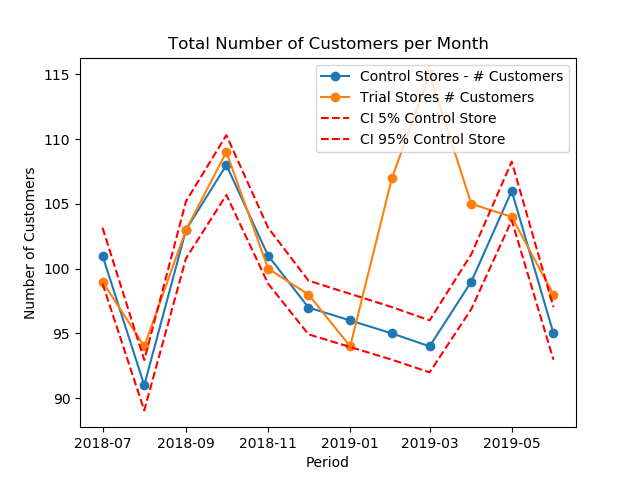

In [148]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(a, '-o', b, '-o', c, '--r', d, '--r')

In [149]:
plt.xlabel('Period')
plt.ylabel('Number of Customers')
plt.title('Total Number of Customers per Month')
plt.legend(['Control Stores - # Customers', 'Trial Stores # Customers', 'CI 5% Control Store', 'CI 95% Control Store'])

## Trial Store 88

In [172]:
storeComparison = 88
# Calculate correlations against store 88 using total sales and number of customers
corr_sales = calculateCorrelation(stores_full_obs_pre_trial, 'Total_Sales', storeComparison)
corr_ncustomers = calculateCorrelation(stores_full_obs_pre_trial, 'N_Customers', storeComparison)

# Calculate magnitude measure against store 88 using total sales and number of customers
magnitude_sales = calculateMagnitudeDistance(stores_full_obs_pre_trial, 'Total_Sales', storeComparison)
magnitude_ncustomers = calculateMagnitudeDistance(stores_full_obs_pre_trial, 'N_Customers', storeComparison)

In [173]:
#### Now, create a combined score composed of correlation and magnitude
corr_sales = corr_sales.rename(columns={'Correlation':'Correlation_Sales'})
magnitude_sales = magnitude_sales.rename(columns={'MagnitudeMeasure': 'Magnitude_Sales'})
corr_ncustomers = corr_ncustomers.rename(columns={'Correlation':'Correlation_NCustomers'})
magnitude_ncustomers = magnitude_ncustomers.rename(columns={'MagnitudeMeasure':'Magnitude_Ncustomers'})

In [174]:
sales = pd.merge(corr_sales, magnitude_sales, left_index=False, right_index=False)
ncustomers = pd.merge(corr_ncustomers, magnitude_ncustomers, left_index=False, right_index=False)

In [175]:
#### Create a combined score composed of correlation and magnitude by merging the correlations table and the magnitudes table, 
#### for each driver.

corr_measure = 0.5
# 1. Sales Table
sales['combined_score_sales'] = ((corr_measure * sales['Correlation_Sales']) + ((1-corr_measure)*sales['Magnitude_Sales']))
sales.head()

,Store1,Store2,Correlation_Sales,Magnitude_Sales,combined_score_sales
0,88.0,1.0,0.813636,0.548959,0.681297
1,88.0,2.0,-0.067927,0.541212,0.236643
2,88.0,3.0,-0.507847,0.458109,-0.024869
3,88.0,4.0,-0.745566,0.484447,-0.130559
4,88.0,5.0,0.190330,0.496409,0.343370


In [176]:
# 2. N_Customers Table
ncustomers['combined_score_ncustomers'] = ((corr_measure*ncustomers['Correlation_NCustomers']) + (1-corr_measure)*ncustomers['Magnitude_Ncustomers'])
ncustomers.head()

,Store1,Store2,Correlation_NCustomers,Magnitude_Ncustomers,combined_score_ncustomers
0,88.0,1.0,0.305334,0.357143,0.331238
1,88.0,2.0,-0.452379,0.285714,-0.083332
2,88.0,3.0,0.522884,0.683673,0.603279
3,88.0,4.0,-0.361503,0.577922,0.108210
4,88.0,5.0,-0.025320,0.558442,0.266561


In [167]:
#### Combine scores across the drivers by merging sales scores and customer scores, and compute a final combined score.
final_score = pd.merge(sales, ncustomers, right_index=False, left_index=False)
final_score = final_score[['Store1', 'Store2', 'combined_score_sales', 'combined_score_ncustomers']]
final_score.head()

,Store1,Store2,combined_score_sales,combined_score_ncustomers
0,88.0,1.0,0.681297,0.331238
1,88.0,2.0,0.236643,-0.083332
2,88.0,3.0,-0.024869,0.603279
3,88.0,4.0,-0.130559,0.108210
4,88.0,5.0,0.343370,0.266561


In [178]:
final_score['final_score'] = ((corr_measure * final_score['combined_score_sales']) + ((1-corr_measure)*final_score['combined_score_ncustomers']))
final_score = final_score.sort_values('final_score', ascending=False)
final_score.head()

,Store1,Store2,combined_score_sales,combined_score_ncustomers,final_score
170,88.0,178.0,0.650803,0.707828,0.679316
12,88.0,14.0,0.646064,0.685774,0.665919
126,88.0,134.0,0.775084,0.540154,0.657619
225,88.0,237.0,0.451974,0.777235,0.614604
179,88.0,187.0,0.616752,0.594560,0.605656


In [186]:
trial = [88]
trial_store = measures[measures['STORE_NBR'].isin(trial)]
c = pd.pivot_table(trial_store, values='Total_Sales', index='MONTH_ID')

control = [178]
control_store = measures[measures['STORE_NBR'].isin(control)]
d = pd.pivot_table(control_store, values='Total_Sales', index='MONTH_ID')

store_14 = [14]
control_store_14 = measures[measures['STORE_NBR'].isin(store_14)]
d1 = pd.pivot_table(control_store_14, values='Total_Sales', index='MONTH_ID')

store_134 = [134]
control_store_134 = measures[measures['STORE_NBR'].isin(store_134)]
d2 = pd.pivot_table(control_store_134, values='Total_Sales', index='MONTH_ID')

store_237 = [237]
control_store_237 = measures[measures['STORE_NBR'].isin(store_237)]
d3 = pd.pivot_table(control_store_237, values='Total_Sales', index='MONTH_ID')

<IPython.core.display.Javascript object>


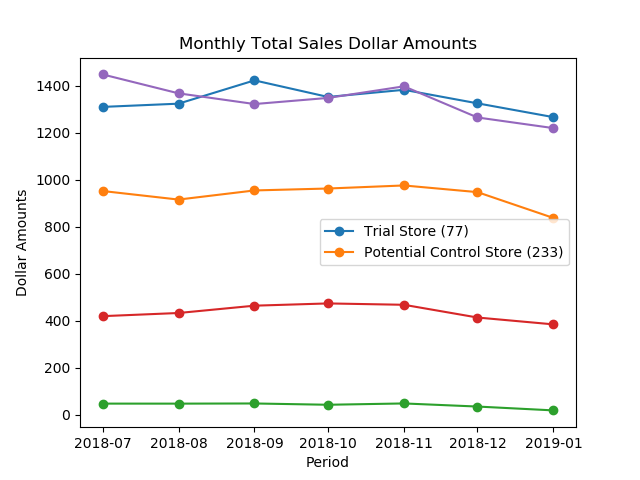

In [187]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(c, '-o', d, '-o', d1, '-o', d2, '-o', d3, '-o')

In [189]:
plt.xlabel('Period')
plt.ylabel('Dollar Amounts')
plt.title('Monthly Total Sales Dollar Amounts')
plt.legend(['Trial Store (88)', 'Store (178)', 'Store (14)', 'Store (134)', 'Store (237)'])

In [208]:
trial = [88]
trial_store = measures[measures['STORE_NBR'].isin(trial)]
c = pd.pivot_table(trial_store, values='N_Customers', index='MONTH_ID')

control = [178]
control_store = measures[measures['STORE_NBR'].isin(control)]
d = pd.pivot_table(control_store, values='N_Customers', index='MONTH_ID')

store_14 = [14]
control_store_14 = measures[measures['STORE_NBR'].isin(store_14)]
d1 = pd.pivot_table(control_store_14, values='N_Customers', index='MONTH_ID')

store_134 = [134]
control_store_134 = measures[measures['STORE_NBR'].isin(store_134)]
d2 = pd.pivot_table(control_store_134, values='N_Customers', index='MONTH_ID')

store_237 = [237]
control_store_237 = measures[measures['STORE_NBR'].isin(store_237)]
d3 = pd.pivot_table(control_store_237, values='N_Customers', index='MONTH_ID')

<IPython.core.display.Javascript object>


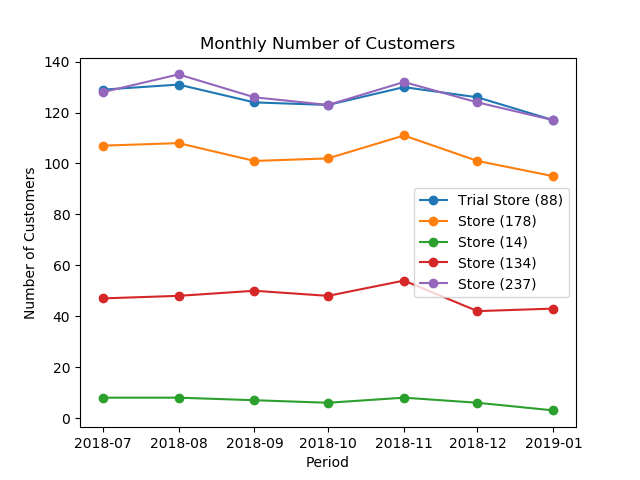

In [209]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(c, '-o', d, '-o', d1, '-o', d2, '-o', d3, '-o')

In [210]:
plt.xlabel('Period')
plt.ylabel('Number of Customers')
plt.title('Monthly Number of Customers')
plt.legend(['Trial Store (88)', 'Store (178)', 'Store (14)', 'Store (134)', 'Store (237)'])

In [ ]:
### Let's now assess the impact of the trial on sales.

In [256]:
#### Scale pre-trial control store sales to match pre-trial trial store sales
pre_trial_trial = stores_full_obs_pre_trial[stores_full_obs_pre_trial['STORE_NBR'] == 88]['Total_Sales'].sum()
pre_trial_control =stores_full_obs_pre_trial[stores_full_obs_pre_trial['STORE_NBR'] == 237]['Total_Sales'].sum()

In [257]:
scalingfactor = pre_trial_trial / pre_trial_control
scalingfactor

1.0015583306649594

In [259]:
#### Apply the scaling factor
store_full_obs_237 = stores_full_obs[stores_full_obs['STORE_NBR'] == 237]
store_full_obs_237['scaled_sales'] = store_full_obs_237['Total_Sales']*scalingfactor
store_full_obs_237 = store_full_obs_237.reset_index(drop=True)
store_full_obs_237 = store_full_obs_237[['MONTH_ID', 'N_Customers', 'scaled_sales']]
store_full_obs_237.head()

C:\Users\7Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,MONTH_ID,N_Customers,scaled_sales
0,201807,128,1450.657086
1,201808,135,1369.931485
2,201809,126,1324.260425
3,201810,123,1350.401097
4,201811,132,1399.777923


In [261]:
trial_sales = stores_full_obs[stores_full_obs['STORE_NBR'] == 88]
trial_sales = trial_sales[['MONTH_ID', 'Total_Sales']].reset_index(drop=True)
trial_sales.head()

,MONTH_ID,Total_Sales
0,201807,1310.0
1,201808,1323.8
2,201809,1423.0
3,201810,1352.4
4,201811,1382.8


In [262]:
#### Calculate the absolute percentage difference between scaled control sales and trial sales
combinedsales = pd.merge(store_full_obs_237, trial_sales, right_index=False, left_index=False)
combinedsales['perdiff'] = abs(combinedsales.scaled_sales - combinedsales.Total_Sales) / combinedsales.scaled_sales
combinedsales

,MONTH_ID,N_Customers,scaled_sales,Total_Sales,perdiff
0,201807,128,1450.657086,1310.00,0.096961
1,201808,135,1369.931485,1323.80,0.033674
2,201809,126,1324.260425,1423.00,0.074562
3,201810,123,1350.401097,1352.40,0.001480
4,201811,132,1399.777923,1382.80,0.012129
5,201812,124,1266.971288,1325.20,0.045959
6,201901,117,1221.600696,1266.40,0.036673
7,201902,126,1406.989143,1370.20,0.026147
8,201903,119,1210.082775,1477.20,0.220743
9,201904,120,1206.477165,1439.40,0.193060


In [263]:
#### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation 
##### based on the scaled percentage difference in the pre-trial period 
std = (combinedsales[combinedsales['MONTH_ID'] < 201902])['perdiff'].std()
std
### degreesOfFreedom <- 7

0.03346786730307889

In [264]:
#### Trial and control store total sales
#### Control store 5th and 95th percentile
combinedsales['MONTH_ID'] = pd.to_datetime(combinedsales['MONTH_ID'], format="%Y%m")
combinedsales['5% CI'] = combinedsales['scaled_sales'] * (1 - std*2)
combinedsales['95% CI'] = combinedsales['scaled_sales'] * (1 + std*2)
combinedsales

,MONTH_ID,N_Customers,scaled_sales,Total_Sales,perdiff,5% CI,95% CI
0,2018-07-01,128,1450.657086,1310.00,0.096961,1353.556288,1547.757884
1,2018-08-01,135,1369.931485,1323.80,0.033674,1278.234114,1461.628855
2,2018-09-01,126,1324.260425,1423.00,0.074562,1235.620080,1412.900769
3,2018-10-01,123,1350.401097,1352.40,0.001480,1260.011008,1440.791187
4,2018-11-01,132,1399.777923,1382.80,0.012129,1306.082759,1493.473086
5,2018-12-01,124,1266.971288,1325.20,0.045959,1182.165634,1351.776942
6,2019-01-01,117,1221.600696,1266.40,0.036673,1139.831956,1303.369436
7,2019-02-01,126,1406.989143,1370.20,0.026147,1312.811291,1501.166995
8,2019-03-01,119,1210.082775,1477.20,0.220743,1129.084996,1291.080555
9,2019-04-01,120,1206.477165,1439.40,0.193060,1125.720730,1287.233600


In [248]:
#### Plotting these in one nice graph
a = pd.pivot_table(combinedsales, values='scaled_sales', index='MONTH_ID')
b = pd.pivot_table(combinedsales, values='Total_Sales', index='MONTH_ID')
c = pd.pivot_table(combinedsales, values='5% CI', index='MONTH_ID')
d = pd.pivot_table(combinedsales, values='95% CI', index='MONTH_ID')

<IPython.core.display.Javascript object>


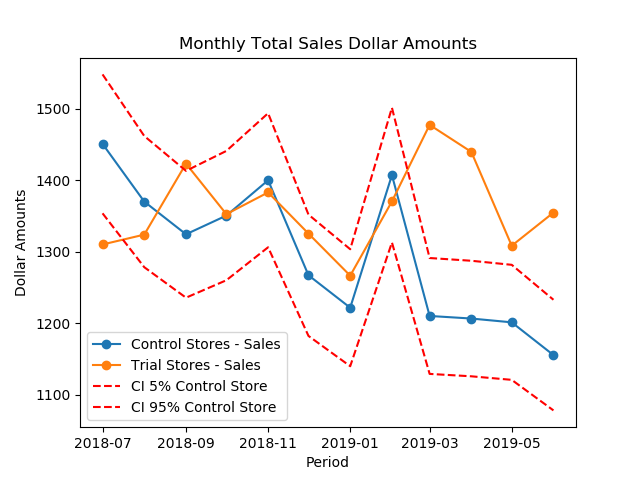

In [250]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(a, '-o', b, '-o', c, '--r', d, '--r')

In [252]:
plt.xlabel('Period')
plt.ylabel('Dollar Amounts')
plt.title('Monthly Total Sales Dollar Amounts')
plt.legend(['Control Stores - Sales', 'Trial Stores - Sales', 'CI 5% Control Store', 'CI 95% Control Store'])

###  Let's have a look at assessing this for number of customers as well.

In [265]:
#### This would be a repeat of the steps before for total sales
#### Scale pre-trial control customers to match pre-trial trial store customers 
pre_trial_trial = stores_full_obs_pre_trial[stores_full_obs_pre_trial['STORE_NBR'] == 88]['N_Customers'].sum()
pre_trial_control = stores_full_obs_pre_trial[stores_full_obs_pre_trial['STORE_NBR'] == 237]['N_Customers'].sum()

In [266]:
scalingfactor = pre_trial_trial / pre_trial_control
scalingfactor

0.9943502824858758

In [269]:
#### Apply the scaling factor
store_full_obs_237['scaled_customers_control'] = store_full_obs_237['N_Customers']*scalingfactor
store_full_obs_237.head()

,MONTH_ID,N_Customers,scaled_sales,scaled_customers_control
0,201807,128,1450.657086,127.276836
1,201808,135,1369.931485,134.237288
2,201809,126,1324.260425,125.288136
3,201810,123,1350.401097,122.305085
4,201811,132,1399.777923,131.254237


In [271]:
store_full_obs_237 = store_full_obs_237[['MONTH_ID', 'scaled_customers_control']].reset_index(drop=True)
store_full_obs_237

,MONTH_ID,scaled_customers_control
0,201807,127.276836
1,201808,134.237288
2,201809,125.288136
3,201810,122.305085
4,201811,131.254237
5,201812,123.299435
6,201901,116.338983
7,201902,125.288136
8,201903,118.327684
9,201904,119.322034


In [272]:
#### Calculate the percentage difference between scaled control sales and trial sales
trial_customers = metrics[metrics['STORE_NBR'] == 88]
trial_customers = trial_customers[['MONTH_ID', 'N_Customers']].reset_index(drop=True)
trial_customers

,MONTH_ID,N_Customers
0,201807,129
1,201808,131
2,201809,124
3,201810,123
4,201811,130
5,201812,126
6,201901,117
7,201902,124
8,201903,134
9,201904,128


In [278]:
customers = pd.merge(store_full_obs_237, trial_customers, left_index=False, right_index=False)
customers.head()

,MONTH_ID,scaled_customers_control,N_Customers
0,201807,127.276836,129
1,201808,134.237288,131
2,201809,125.288136,124
3,201810,122.305085,123
4,201811,131.254237,130


In [280]:
#### Calculate the percentage difference between scaled control # customers and trial # customers
customers['percentage_difference'] = abs(customers.scaled_customers_control - customers.N_Customers) / customers.scaled_customers_control
customers

,MONTH_ID,scaled_customers_control,N_Customers,percentage_difference
0,201807,127.276836,129,0.013539
1,201808,134.237288,131,0.024116
2,201809,125.288136,124,0.010281
3,201810,122.305085,123,0.005682
4,201811,131.254237,130,0.009556
5,201812,123.299435,126,0.021902
6,201901,116.338983,117,0.005682
7,201902,125.288136,124,0.010281
8,201903,118.327684,134,0.132448
9,201904,119.322034,128,0.072727


In [281]:
#### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation
#### based on the scaled percentage difference in the pre-trial period
std = (customers[customers['MONTH_ID'] < 201902])['percentage_difference'].std()
std
## degreesOfFreedom <- 7

0.00741024435207507

In [282]:
#### Trial and control store number of customers
#### Control store 95th & 5th percentile
#control = customers[['MONTH_ID', 'scaled_customers_control']]
customers['MONTH_ID'] = pd.to_datetime(customers['MONTH_ID'], format="%Y%m")                    
#control = control.set_index('MONTH_ID')
customers['5% CI'] = customers['scaled_customers_control'] * (1 - std*2)
customers['95% CI'] = customers['scaled_customers_control'] * (1 + std*2)
customers.head()

,MONTH_ID,scaled_customers_control,N_Customers,percentage_difference,5% CI,95% CI
0,2018-07-01,127.276836,129,0.013539,125.390531,129.163141
1,2018-08-01,134.237288,131,0.024116,132.247826,136.226750
2,2018-09-01,125.288136,124,0.010281,123.431304,127.144967
3,2018-10-01,122.305085,123,0.005682,120.492464,124.117706
4,2018-11-01,131.254237,130,0.009556,129.308985,133.199489


In [283]:
#### Plotting these in one nice graph
a = pd.pivot_table(customers, values='scaled_customers_control', index='MONTH_ID')
b = pd.pivot_table(customers, values='N_Customers', index='MONTH_ID')
c = pd.pivot_table(customers, values='5% CI', index='MONTH_ID')
d = pd.pivot_table(customers, values='95% CI', index='MONTH_ID')

<IPython.core.display.Javascript object>


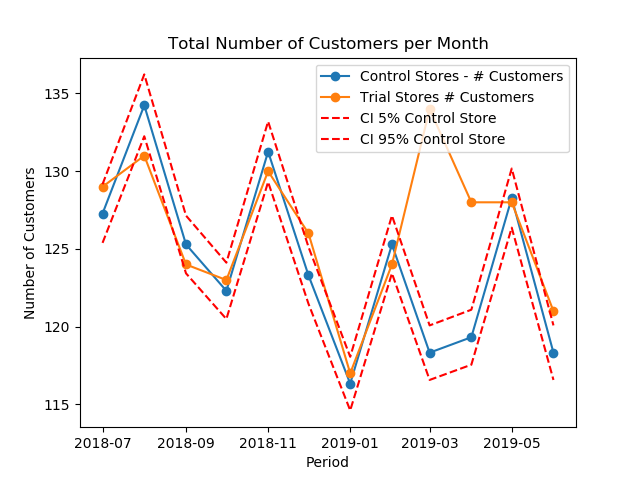

In [284]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(a, '-o', b, '-o', c, '--r', d, '--r')

In [285]:
plt.xlabel('Period')
plt.ylabel('Number of Customers')
plt.title('Total Number of Customers per Month')
plt.legend(['Control Stores - # Customers', 'Trial Stores # Customers', 'CI 5% Control Store', 'CI 95% Control Store'])

# Conclusion
Good work! We've found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.

The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales. Now that we have finished our analysis, we can prepare our presentation to the Category Manager.